# Содержательное описание задачи

«Набор данных о поведении клиентов и покупках в электронной коммерции» — это синтетический набор данных, созданный с использованием библиотеки Faker Python. Он моделирует комплексную среду электронной коммерции, фиксируя различные аспекты поведения клиентов и историю покупок на цифровом рынке. Этот набор данных подходит для таких задач, как прогнозирование оттока клиентов, анализ потребительской корзины, системы рекомендаций и анализ тенденций.

---
Задача прогнозирования состоит в том, чтобы определить отток клиентов. То есть опираясь на предложенные данные нужно  решить задачу классифицикации с двумя классами:


*   Клиент ушёл
*   Клиент остался

**Загрузка данных**

In [1]:
import numpy as np              # Одномерные и многомерные массивы (array)
import pandas as pd             # Таблицы и временные ряды (dataframe, series)
import matplotlib.pyplot as plt # Научная графика
import seaborn as sns           # Еще больше красивой графики для визуализации данных
import sklearn                  # Алгоритмы машинного обучения
%matplotlib inline

data = pd.read_csv("/content/ecommerce_customer_data_large.csv")
data.head()      # Выведем несколько строк датасета

,Customer ID,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Customer Age,Returns,Customer Name,Age,Gender,Churn
0,44605,2023-05-03 21:30:02,Home,177,1,2427,PayPal,31,1.0,John Rivera,31,Female,0
1,44605,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,31,1.0,John Rivera,31,Female,0
2,44605,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,31,1.0,John Rivera,31,Female,0
3,44605,2023-01-17 13:14:36,Electronics,396,3,937,Cash,31,0.0,John Rivera,31,Female,0
4,44605,2021-05-01 11:29:27,Books,259,4,2598,PayPal,31,1.0,John Rivera,31,Female,0


In [2]:
data.shape      # Размерность датасета (Объём данных: 250000 (строк); количество признаков: 13 (столбцов))

(250000, 13)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 13 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   Customer ID            250000 non-null  int64  
 1   Purchase Date          250000 non-null  object 
 2   Product Category       250000 non-null  object 
 3   Product Price          250000 non-null  int64  
 4   Quantity               250000 non-null  int64  
 5   Total Purchase Amount  250000 non-null  int64  
 6   Payment Method         250000 non-null  object 
 7   Customer Age           250000 non-null  int64  
 8   Returns                202618 non-null  float64
 9   Customer Name          250000 non-null  object 
 10  Age                    250000 non-null  int64  
 11  Gender                 250000 non-null  object 
 12  Churn                  250000 non-null  int64  
dtypes: float64(1), int64(7), object(5)
memory usage: 24.8+ MB


**Набор данных содержит следующие столбцы:**



1.   Customer ID: уникальный идентификатор для каждого клиента.
2.   Purchase Date: дата каждой покупки, совершенной покупателем.
3.   Product Category: категория или тип приобретенного продукта.
4.   Product Price: цена приобретенного продукта.
5.   Quantity: количество приобретенного товара.
6.   Total Purchase Amount: общая сумма, потраченная клиентом в каждой транзакции.
7.   Payment Method : способ оплаты, используемый клиентом.
8.   Customer Age: возраст клиента (генерируется Faker).
9.   Returns: возвратил ли клиент какие-либо продукты из заказа (двоичный код: 0 — возврат невозвратный, 1 — возврат).
10.  Customer Name: имя клиента.
11.  Age: возраст клиента.
12.  Gender: пол клиента.
13.  Churn: двоичный столбец, показывающий, ушел ли клиент (0 — клиент остался, 1 — клиент ушёл). Целевой признак (предсказываемое значение).

Признаки Returns и Churn - бинарные.

Признаки Genre, Product Category, Payment Method - категориальные (нормированнные).

Признаки Customer ID, Product Price, Quantity, Total Purchase Amount, Customer Age, Age - числовые (непрерывные).

Даты (признак Purchase Date) нужно преобразовать из строк в дату и время.

---

Исключим признаки, которые не стоит использовать для обучения модели, так как она не влияют на решение клиента перестать пользоваться услугами магазина: Customer ID, Customer Name. Признаки Age и Customer Age дублируют друг друга, поэтому один из них можно исключить.

Бинарные признаки можно считать как категориальными неупорядоченными так и числовыми. В данной задаче примем признаки Returns и Churn за категориальные признаки (возвраты можно разделить на 2 категории: был возврат или нет. То же самое и с уходом клиента).

In [4]:
df = data.drop(['Customer ID', 'Customer Name', 'Customer Age'], axis=1)
df['Purchase Date'] = pd.to_datetime(df['Purchase Date'])
df.head()

,Purchase Date,Product Category,Product Price,Quantity,Total Purchase Amount,Payment Method,Returns,Age,Gender,Churn
0,2023-05-03 21:30:02,Home,177,1,2427,PayPal,1.0,31,Female,0
1,2021-05-16 13:57:44,Electronics,174,3,2448,PayPal,1.0,31,Female,0
2,2020-07-13 06:16:57,Books,413,1,2345,Credit Card,1.0,31,Female,0
3,2023-01-17 13:14:36,Electronics,396,3,937,Cash,0.0,31,Female,0
4,2021-05-01 11:29:27,Books,259,4,2598,PayPal,1.0,31,Female,0


Преобразуем признаки Product Category, Payment Method, Gender, Returns и Churn к типу category

In [5]:
df['Product Category'] = df['Product Category'].astype('category')
df['Payment Method'] = df['Payment Method'].astype('category')
df['Gender'] = df['Gender'].astype('category')
df['Returns'] = df['Returns'].astype('category')
df['Churn'] = df['Churn'].astype('category')

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 10 columns):
 #   Column                 Non-Null Count   Dtype         
---  ------                 --------------   -----         
 0   Purchase Date          250000 non-null  datetime64[ns]
 1   Product Category       250000 non-null  category      
 2   Product Price          250000 non-null  int64         
 3   Quantity               250000 non-null  int64         
 4   Total Purchase Amount  250000 non-null  int64         
 5   Payment Method         250000 non-null  category      
 6   Returns                202618 non-null  category      
 7   Age                    250000 non-null  int64         
 8   Gender                 250000 non-null  category      
 9   Churn                  250000 non-null  category      
dtypes: category(5), datetime64[ns](1), int64(4)
memory usage: 10.7 MB


# Информация о числовых значениях

In [6]:
df.describe(include=['int64'])

,Product Price,Quantity,Total Purchase Amount,Age
count,250000.000000,250000.000000,250000.000000,250000.000000
mean,254.742724,3.004936,2725.385196,43.798276
std,141.738104,1.414737,1442.576095,15.364915
min,10.000000,1.000000,100.000000,18.000000
25%,132.000000,2.000000,1476.000000,30.000000
50%,255.000000,3.000000,2725.000000,44.000000
75%,377.000000,4.000000,3975.000000,57.000000
max,500.000000,5.000000,5350.000000,70.000000


*   min – минимальное значение признака
*   max – максимальное значение признака
*   mean – среднее значение
*   std – среднеквадратическое отклонение
*   25% – первый квартиль – значение, ниже которого лежит 25% значений
*   50% – медиана – значение, 50% значений меньше которого, а другие 50% больше
*   75% – третий квартиль – значение, ниже которого лежит около 75% значений

  Нет пропущенных значений.

**Построим матрицу корелляции для числовых признаков:**

In [7]:
corrMatrix = df.select_dtypes(include=['int64']).corr()
corrMatrix.style.background_gradient(cmap='coolwarm', vmin=-1, vmax=1)

,Product Price,Quantity,Total Purchase Amount,Age
Product Price,1.000000,0.002339,-0.001297,0.002214
Quantity,0.002339,1.000000,0.001234,-0.000180
Total Purchase Amount,-0.001297,0.001234,1.000000,0.056552
Age,0.002214,-0.000180,0.056552,1.000000


Очень странно, что цена продукта не кореллирует с общей суммой покупки. Также странно, что количество приобретённого товара не кореллирует с итоговой стоимостью. Наблюдается наибольшая кореляция возраста клиента и итоговой стоимости.

Из этого можно сделать вывод о ненадёжности данных. Скорее всего такая ошибка возникла из-за их неправильной генерации.

---

Сильно коррелированные друг с другом переменные дают модели одну и ту же информацию, следовательно, для анализа не нужно использовать их все. В таком случае в модели можно оставить только одну из этих переменных. Если использовать все, то модель окажется переобучена и предвзята относительно одного отдельного признака.

В данном случае переменные Product Price и Total Purchase Amount должны коррелировать. Однако этого не наблюдается скорее всего из-за неправильной генерации данных. На некоторых примерах можно увидеть, что итоговая цена не равна произведению количества товара на его стоимость. Поэтому было принято решение исключить переменную Total Purchase Amount, во-первых, во избежание ошибок, во-вторых, как сильно коррелирующую с Product Price.

In [8]:
df = df.drop(['Total Purchase Amount'], axis=1)
df.head()

,Purchase Date,Product Category,Product Price,Quantity,Payment Method,Returns,Age,Gender,Churn
0,2023-05-03 21:30:02,Home,177,1,PayPal,1.0,31,Female,0
1,2021-05-16 13:57:44,Electronics,174,3,PayPal,1.0,31,Female,0
2,2020-07-13 06:16:57,Books,413,1,Credit Card,1.0,31,Female,0
3,2023-01-17 13:14:36,Electronics,396,3,Cash,0.0,31,Female,0
4,2021-05-01 11:29:27,Books,259,4,PayPal,1.0,31,Female,0


# Информация о категориальных и бинарных признаках

In [9]:
df.describe(include=['category'])

,Product Category,Payment Method,Returns,Gender,Churn
count,250000,250000,202618.0,250000,250000
unique,4,3,2.0,2,2
top,Electronics,Credit Card,1.0,Male,0
freq,62630,83547,101476.0,125676,199870


*   unique - это количество уникальных значений в признаке
*   top - это наиболее распространенное значение
*   freq - это частота наиболее распространенного значения


---


1. Мы можем видеть, что есть 4 уникальных категории продуктов и 3 уникальных категории методов оплаты.
2. Наиболее распространенная категория продуктов - это электроника.
3. Наиболее распространенная категория методов оплаты - это оплата по кредитной карте.
4. Большинство покупателей - мужчины, но их не намного больше, чем женщин. Процентное соотношение почти 50 на 50.
5. Наиболее распространенён возврат товаров и уход (отток) клиентов.
6. При том, что было сделано меньше половины возвратов (около 40%  без учёта пропущенных значений), отток клиентов составляет около 80%.

Имеются пропущенные значения (у признака Returns).

# Визуализация данных

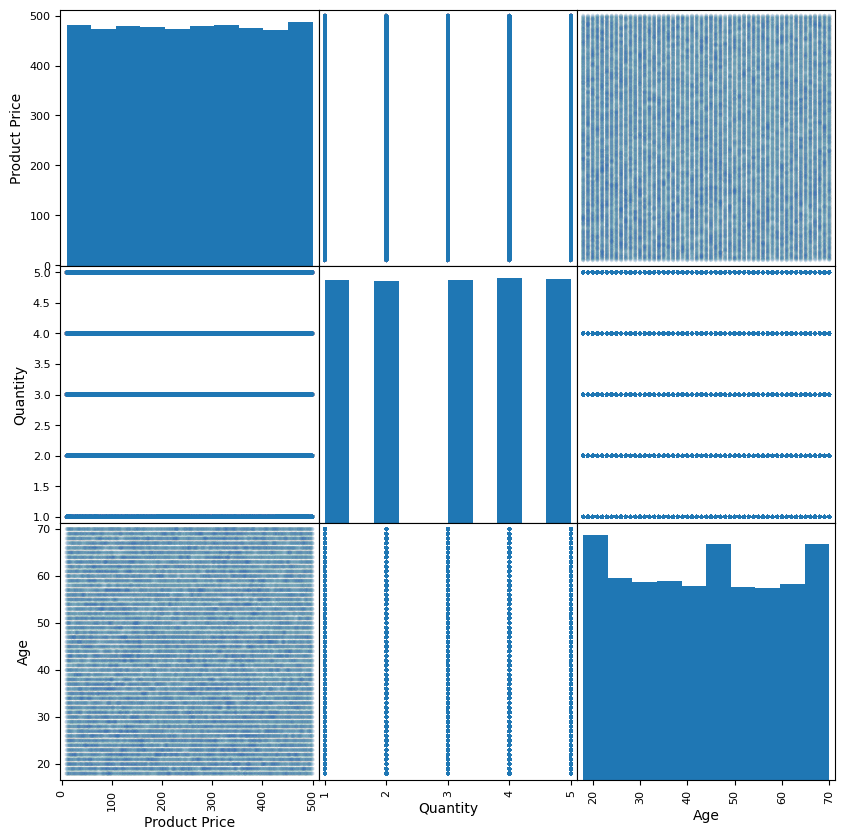

In [11]:
from pandas.plotting import scatter_matrix
scatter_matrix(df, alpha = .01, figsize = (10, 10))
pass

array([[<Axes: title={'center': 'Purchase Date'}>,
        <Axes: title={'center': 'Product Price'}>,
        <Axes: title={'center': 'Quantity'}>],
       [<Axes: title={'center': 'Age'}>, <Axes: >, <Axes: >],
       [<Axes: >, <Axes: >, <Axes: >]], dtype=object)

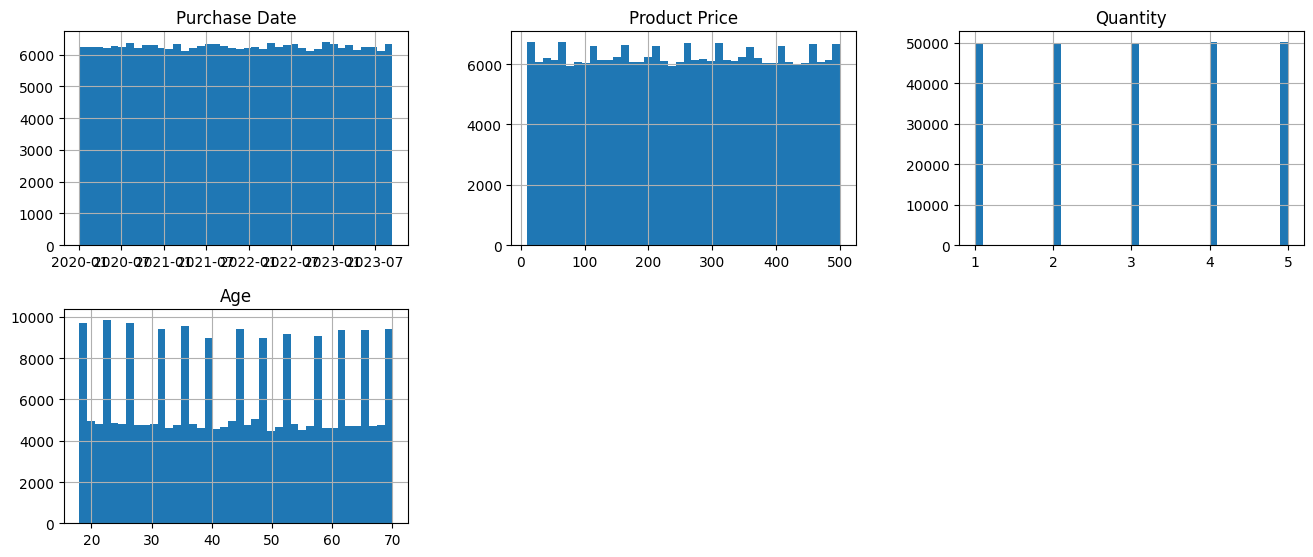

In [12]:
df.hist(bins=40, layout=(3,3), figsize=(16,10))

По гистограммам выбросы не наблюдаются.

# Обработка пропущенных значений

Эффективным и простым методом обработки является заполнение пропущенных значений для каждой количественной переменной их средним или медианным значением. Для категориальных признаков пропущенные значения можно заполнить самым популярным значением в столбце.

In [13]:
df.isnull().sum()

,0
Purchase Date,0
Product Category,0
Product Price,0
Quantity,0
Payment Method,0
Returns,47382
Age,0
Gender,0
Churn,0


Убедились, что пропущенные значения есть только у категориального признака Returns

In [14]:
df['Returns'].describe()

,Returns
count,202618.0
unique,2.0
top,1.0
freq,101476.0


In [15]:
df['Returns'] = df['Returns'].fillna(1.0)
df['Returns'].describe()

,Returns
count,250000.0
unique,2.0
top,1.0
freq,148858.0


# Обработка категориальных признаков

 Закодируем категориальные признаки с использованием OneHotEncoder числовыми признаками.



In [16]:
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(drop='if_binary', sparse_output=False)
enc.fit(df[['Product Category',	'Payment Method', 'Gender', 'Returns', 'Churn']])

dummies = pd.DataFrame(enc.transform(df[['Product Category',	'Payment Method', 'Gender', 'Returns', 'Churn']]),
                       columns=enc.get_feature_names_out(), index=df.index)

In [17]:
data1 = pd.concat((df, dummies), axis=1).drop(['Product Category',	'Payment Method', 'Gender', 'Returns', 'Churn'], axis=1)
data1.head()

,Purchase Date,Product Price,Quantity,Age,Product Category_Books,Product Category_Clothing,Product Category_Electronics,Product Category_Home,Payment Method_Cash,Payment Method_Credit Card,Payment Method_PayPal,Gender_Male,Returns_1.0,Churn_1
0,2023-05-03 21:30:02,177,1,31,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
1,2021-05-16 13:57:44,174,3,31,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
2,2020-07-13 06:16:57,413,1,31,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
3,2023-01-17 13:14:36,396,3,31,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2021-05-01 11:29:27,259,4,31,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0


In [18]:
data1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 14 columns):
 #   Column                        Non-Null Count   Dtype         
---  ------                        --------------   -----         
 0   Purchase Date                 250000 non-null  datetime64[ns]
 1   Product Price                 250000 non-null  int64         
 2   Quantity                      250000 non-null  int64         
 3   Age                           250000 non-null  int64         
 4   Product Category_Books        250000 non-null  float64       
 5   Product Category_Clothing     250000 non-null  float64       
 6   Product Category_Electronics  250000 non-null  float64       
 7   Product Category_Home         250000 non-null  float64       
 8   Payment Method_Cash           250000 non-null  float64       
 9   Payment Method_Credit Card    250000 non-null  float64       
 10  Payment Method_PayPal         250000 non-null  float64       
 11  Gender_Male  

# Нормализация

Проводим MinMax нормализацию, чтобы все нормируемые переменные были в диапазоне от 0 до 1.

In [19]:
cols_to_norm = ['Product Price', 'Quantity',	'Age']
data_numerical = data1[cols_to_norm]
data_numerical.describe()

,Product Price,Quantity,Age
count,250000.000000,250000.000000,250000.000000
mean,254.742724,3.004936,43.798276
std,141.738104,1.414737,15.364915
min,10.000000,1.000000,18.000000
25%,132.000000,2.000000,30.000000
50%,255.000000,3.000000,44.000000
75%,377.000000,4.000000,57.000000
max,500.000000,5.000000,70.000000


In [20]:
data1[cols_to_norm] = (data_numerical - data_numerical.min(axis = 0))/(data_numerical.max(axis = 0) - data_numerical.min(axis = 0))
data1[cols_to_norm].describe()

,Product Price,Quantity,Age
count,250000.000000,250000.000000,250000.000000
mean,0.499475,0.501234,0.496121
std,0.289261,0.353684,0.295479
min,0.000000,0.000000,0.000000
25%,0.248980,0.250000,0.230769
50%,0.500000,0.500000,0.500000
75%,0.748980,0.750000,0.750000
max,1.000000,1.000000,1.000000


In [21]:
data1[cols_to_norm].head()

,Product Price,Quantity,Age
0,0.340816,0.00,0.25
1,0.334694,0.50,0.25
2,0.822449,0.00,0.25
3,0.787755,0.50,0.25
4,0.508163,0.75,0.25


Если мы будем использовать классификатор ближайших соседей (knn), то следует учесть, что разные атрибуты обычно обладают разным диапазоном представленных значений в выборке. Значения дистанции могут сильно зависеть от атрибутов с более широкими диапазонами. Поэтому данные обычно подлежат нормализации.

Однако, учитывая размер исходного датасета(250000 строк) и необходимость хранить обучающую выборку при использовании классификатора ближайших соседей, был сделан выбор использовать случайный лес.

# Разбиение на обучающую и тестовую выборки

In [22]:
from sklearn.model_selection import train_test_split

data1['Purchase Date'] = data1['Purchase Date'].astype('int64') / 10**9

y = data1['Churn_1']
X = data1.drop(columns=['Churn_1'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

N_train, _ = X_train.shape
N_test,  _ = X_test.shape

N_train, N_test       # количество строк в обучающей и тестовой выборках

(200000, 50000)

Разбили выборку на обучающую, которая составляет 80% от изначальной выборки, и тестовую - 20% от изначальной выборки.

# Случайный лес

В качестве классификатора был выбран случайный лес ввиду его высокой точности, устойчивости к переобучению и способности к эффективной обработке больших объёмов данных.

In [23]:
from sklearn.model_selection import GridSearchCV
from sklearn import ensemble

rf = ensemble.RandomForestClassifier()

grid = GridSearchCV(rf, cv=5, param_grid = {'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9]},scoring='roc_auc',verbose = 2)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ......................max_depth=3, max_leaf_nodes=3; total time=   6.5s
[CV] END ......................max_depth=3, max_leaf_nodes=3; total time=   5.1s
[CV] END ......................max_depth=3, max_leaf_nodes=3; total time=   6.5s
[CV] END ......................max_depth=3, max_leaf_nodes=3; total time=   5.4s
[CV] END ......................max_depth=3, max_leaf_nodes=3; total time=   6.8s
[CV] END ......................max_depth=3, max_leaf_nodes=6; total time=   6.3s
[CV] END ......................max_depth=3, max_leaf_nodes=6; total time=   7.0s
[CV] END ......................max_depth=3, max_leaf_nodes=6; total time=   6.1s
[CV] END ......................max_depth=3, max_leaf_nodes=6; total time=   7.0s
[CV] END ......................max_depth=3, max_leaf_nodes=6; total time=   6.3s
[CV] END ......................max_depth=3, max_leaf_nodes=9; total time=   7.5s
[CV] END ......................max_depth=3, max_l

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 6, 9], 'max_leaf_nodes': [3, 6, 9]},
             scoring='roc_auc', verbose=2)

# Выбор оптимального значения гиперпараметра

In [24]:
grid.best_params_

{'max_depth': 6, 'max_leaf_nodes': 6}

**Обучение модели**

In [25]:
rfst = ensemble.RandomForestClassifier(max_depth = grid.best_params_['max_depth'],max_leaf_nodes = grid.best_params_['max_leaf_nodes'])
rfst.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_leaf_nodes=6)

# Вычисление ошибки на обучающей и тестовой выборке

In [26]:
err_train = np.mean(y_train != rfst.predict(X_train))
err_test  = np.mean(y_test  != rfst.predict(X_test))

print(err_train, err_test)

0.20073 0.19968


# Промежуточные итоги

Вывод матрицы ошибок

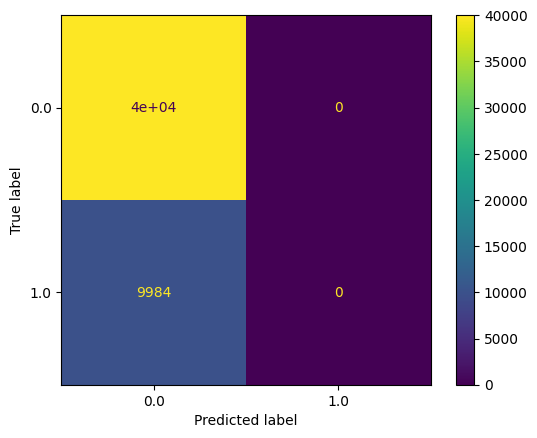

In [27]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, rfst.predict(X_test))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rfst.classes_)
disp.plot()
plt.show()

Из-за дисбаланса классов возникает следующая проблема. В нашем датасете преобладает число удержанных клиентов над числом ушедших (80%/20%). Так как на обучающей выборке число ушедших покупателей было мало, мы не смогли получить хороших результатов в определении ушедших покупателей. Фактически мы получили константную модель, которая всем присвоила 0.

# Борьба с несбалонсированностью классов

**1. Взвешивание классов (Class Weighting)**

Принцип работы взвешивания классов заключается в присвоении разных весов каждому классу в зависимости от его доли в данных. Это позволяет модели лучше справляться с классом-меньшинством.

In [28]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier

# Получение весов классов
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

# Создание модели с взвешиванием классов
model = RandomForestClassifier(class_weight=class_weights)

grid_balanced = GridSearchCV(model, cv=5, param_grid = {'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9]},scoring='roc_auc',verbose = 2)
grid_balanced.fit(X_train, y_train)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ......................max_depth=3, max_leaf_nodes=3; total time=   6.7s
[CV] END ......................max_depth=3, max_leaf_nodes=3; total time=   5.4s
[CV] END ......................max_depth=3, max_leaf_nodes=3; total time=   6.5s
[CV] END ......................max_depth=3, max_leaf_nodes=3; total time=   5.3s
[CV] END ......................max_depth=3, max_leaf_nodes=3; total time=   6.5s
[CV] END ......................max_depth=3, max_leaf_nodes=6; total time=   6.5s
[CV] END ......................max_depth=3, max_leaf_nodes=6; total time=   7.1s
[CV] END ......................max_depth=3, max_leaf_nodes=6; total time=   6.8s
[CV] END ......................max_depth=3, max_leaf_nodes=6; total time=   7.5s
[CV] END ......................max_depth=3, max_leaf_nodes=6; total time=   6.2s
[CV] END ......................max_depth=3, max_leaf_nodes=9; total time=   7.2s
[CV] END ......................max_depth=3, max_l

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(class_weight={0.0: 0.6255708333854643,
                                                            1.0: 2.4909081851242965}),
             param_grid={'max_depth': [3, 6, 9], 'max_leaf_nodes': [3, 6, 9]},
             scoring='roc_auc', verbose=2)

Выбор оптимального значения гиперпараметра

In [29]:
grid_balanced.best_params_

{'max_depth': 6, 'max_leaf_nodes': 6}

Обучение модели

In [30]:
rfst_balanced = ensemble.RandomForestClassifier(max_depth = grid_balanced.best_params_['max_depth'],max_leaf_nodes = grid_balanced.best_params_['max_leaf_nodes'])
rfst_balanced.fit(X_train, y_train)

RandomForestClassifier(max_depth=6, max_leaf_nodes=6)

Вычисление ошибки на обучающей и тестовой выборке

In [31]:
err_train_balanced = np.mean(y_train != rfst_balanced.predict(X_train))
err_test_balanced  = np.mean(y_test  != rfst_balanced.predict(X_test))

print(err_train_balanced, err_test_balanced)

0.20073 0.19968


**2. Уменьшение выборки**

Уменьшение выборки заключается в уменьшении количества примеров в классе-большинстве, чтобы сделать его менее доминирующим.

In [32]:
from imblearn.under_sampling import RandomUnderSampler

# Создание экземпляра RandomUnderSampler
rus = RandomUnderSampler()

# Применение уменьшения выборки к данным
X_resampled, y_resampled = rus.fit_resample(X, y)

In [33]:
X_train_resampled, X_test_resampled, y_train_resampled, y_test_resampled = train_test_split(X_resampled, y_resampled, test_size = 0.2, random_state = 42)

N_train_resampled, _ = X_train_resampled.shape
N_test_resamples,  _ = X_test_resampled.shape

N_train_resampled, N_test_resamples

(80208, 20052)

In [34]:
rf_resampled = ensemble.RandomForestClassifier()

grid_resampled = GridSearchCV(rf_resampled, cv=5, param_grid = {'max_depth': [3, 6, 9],
    'max_leaf_nodes': [3, 6, 9]},scoring='roc_auc',verbose = 2)
grid_resampled.fit(X_train_resampled, y_train_resampled)

Fitting 5 folds for each of 9 candidates, totalling 45 fits
[CV] END ......................max_depth=3, max_leaf_nodes=3; total time=   2.4s
[CV] END ......................max_depth=3, max_leaf_nodes=3; total time=   2.6s
[CV] END ......................max_depth=3, max_leaf_nodes=3; total time=   2.7s
[CV] END ......................max_depth=3, max_leaf_nodes=3; total time=   2.1s
[CV] END ......................max_depth=3, max_leaf_nodes=3; total time=   2.0s
[CV] END ......................max_depth=3, max_leaf_nodes=6; total time=   2.3s
[CV] END ......................max_depth=3, max_leaf_nodes=6; total time=   2.3s
[CV] END ......................max_depth=3, max_leaf_nodes=6; total time=   3.3s
[CV] END ......................max_depth=3, max_leaf_nodes=6; total time=   2.5s
[CV] END ......................max_depth=3, max_leaf_nodes=6; total time=   2.3s
[CV] END ......................max_depth=3, max_leaf_nodes=9; total time=   2.4s
[CV] END ......................max_depth=3, max_l

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [3, 6, 9], 'max_leaf_nodes': [3, 6, 9]},
             scoring='roc_auc', verbose=2)

Выбор оптимального значения гиперпараметра

In [35]:
grid_resampled.best_params_

{'max_depth': 6, 'max_leaf_nodes': 9}

Обучение модели

In [36]:
rfst_resampled = ensemble.RandomForestClassifier(max_depth = grid_resampled.best_params_['max_depth'],max_leaf_nodes = grid_resampled.best_params_['max_leaf_nodes'])
rfst_resampled.fit(X_train_resampled, y_train_resampled)

RandomForestClassifier(max_depth=6, max_leaf_nodes=9)

Вычисление ошибки на обучающей и тестовой выборке

In [37]:
err_train_resampled = np.mean(y_train_resampled != rfst_resampled.predict(X_train_resampled))
err_test_resampled  = np.mean(y_test_resampled  != rfst_resampled.predict(X_test_resampled))

print(err_train_resampled, err_test_resampled)

0.4726835228406144 0.486983842010772


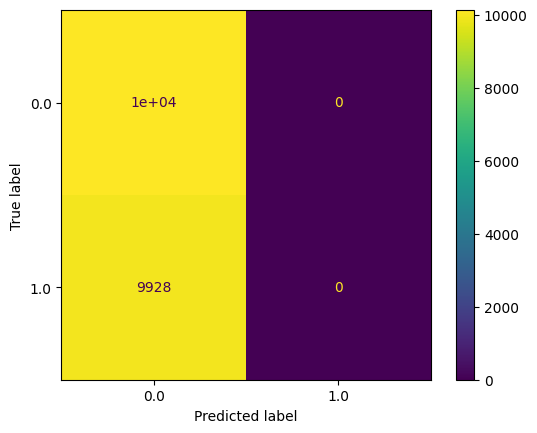

In [38]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test_resampled, rfst.predict(X_test_resampled))
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = rfst_resampled.classes_)
disp.plot()
plt.show()

# Итоги

Ни один из методов борьбы с несбалансированными классами не дал желаемого результата.

*   Модель с взвешиванием классов показала точно такие же значения ошибок на обучающей и тестовой выборках.
*    Хотя после уменьшения выборки ошибки на обучающей и тестовой выборках даже увеличились, модель после обучения продолжает предсказывать на тесте только нули, что свидетельствует об очень плохом качестве модели.

Скорее всего это свидетельствует о проблеме в самих данных и о возможных ошибках при их генерации.